In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## 线性回归找最佳拟合直线

平方误差
$$ \sum_{i=1}^{m}(y_i - x_i^Tw)^2 $$
用矩阵还可以写作$ (y-Xw)^T(y-Xw) $。如果对w求导，得到 $ X^T(Y_Xw) $，令其等于零，解出w如下：
$$ \hat{w} = (X^TX)^{-1}X^Ty $$

该方法也称为OLS，即普通最小二乘法（Oridinary Least Squares）

In [2]:
def load_data_set(filename):
    num_feat = len(open(filename).readline().split('\t')) - 1
    data_mat = []
    label_mat = []
    fr = open(filename)
    for line in fr.readlines():
        line_arr = []
        cur_line = line.strip().split('\t')
        for i in range(num_feat):
            line_arr.append(float(cur_line[i]))
        data_mat.append(line_arr)
        label_mat.append(float(cur_line[-1]))
    return data_mat, label_mat


def stand_regres(x_arr, y_arr):
    """
    标准回归函数
    :param x_arr: 特征
    :param y_arr: 标签
    :return: 回归系数
    """
    x_mat = np.mat(x_arr)
    y_mat = np.mat(y_arr).T
    x_tx = x_mat.T * x_mat
    if np.linalg.det(x_tx) == 0.0:  # 求行列式
        print("the matrix is singular, cannot do inverse")
        return
    ws = x_tx.I * (x_mat.T * y_mat)  # 或者 ws = linalg.solve(x_tx, x_mat.T * y_mat)
    return ws

In [3]:
x_arr, y_arr = load_data_set('data/regression/ex0.txt')

ws = stand_regres(x_arr, y_arr)

x_mat = np.mat(x_arr)
y_mat = np.mat(y_arr)

y_hat = x_mat * ws

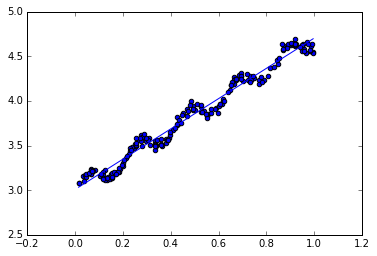

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_mat[:, 1].flatten().A[0], y_mat.T[:, 0].flatten().A[0])

x_copy = x_mat.copy()
x_copy.sort(0)
y_hat = x_copy * ws
ax.plot(x_copy[:, 1], y_hat)
plt.show()

## 局部加权线性回归

局部加权线性回归（Locally Weighted Linear Regression, LWLR)是给待预测点附近的每一个点赋予一定的权重。
$$ \hat{w} = (X^TWX)^{-1}X^TWy $$
其中W是一个矩阵，用来给每一个数据点赋予权重

LWLR使用“核”来对附近的点赋予更高的权重。高斯核是一个常用的核：
$$ W(i,i) = exp\big{(}\frac{|x^{(i)} - x|}{-2k^2}\big{)} $$
这样就构建了一个只含对角元素的权重矩阵W，并且点x与x(i)越近，W(i,1)将越大。k是这里唯一需要考虑的参数，它决定了对附近的点赋予多大的权重。显然，k很小时，除了距x(i)很近的点，$ \frac{|x^{(i)} - x|}{-2k^2} $ 会趋近于0。所以，k取值过小会导致回归时考虑的点少，进而出现过拟合线现象。

比直线拟合效果好，但是计算量大。

In [5]:
def lwlr(test_point, x_arr, y_arr, k=1.0):
    """
    局部加权线性回归函数
    :param test_point: 测试点的特征
    :param x_arr: 所有样本的特征
    :param y_arr: 所有样本的标签
    :param k:
    :return: 测试点的预测值
    """
    x_mat = np.mat(x_arr)
    y_mat = np.mat(y_arr)
    m = np.shape(x_mat)[0]
    weights = np.mat(np.eye((m)))  # 创建对角矩阵

    for j in range(m):
        # 随着样本点与待预测点距离的递增，权重值大小以指数级衰减
        diff_mat = test_point - x_mat[j, :]
        weights[j, j] = np.exp(diff_mat * diff_mat.T / (-2.0*k**2))
    x_tx = x_mat.T * (weights * x_mat)
    if np.linalg.det(x_tx) == 0.0:
        print("the matrix is singular, cannout do inverse")
        return
    ws = x_tx.I * (x_mat.T * (weights * y_mat.T))
    return test_point * ws


def lwlr_test(test_arr, x_arr, y_arr, k=1.0):
    m = np.shape(test_arr)[0]
    y_hat = np.zeros(m)
    for i in range(m):
        y_hat[i] = lwlr(test_arr[i], x_arr, y_arr, k)
    return y_hat

# 选取一个样本测试
x_arr, y_arr = load_data_set('data/regression/ex0.txt')
print(y_arr[0])
y0_hat = lwlr(x_arr[0], x_arr, y_arr, 1.0)
print(y0_hat)
y0_hat = lwlr(x_arr[0], x_arr, y_arr, 0.001)
print(y0_hat)

x_mat = np.mat(x_arr)
srt_ind = x_mat[:,1].argsort(0)
x_sort = x_mat[srt_ind][:,0,:]

k_list = [1, 0.01, 0.003]
y_hat_list = []

for i in range(len(k_list)):
    # 测试所有样本
    y_hat_list.append(lwlr_test(x_arr, x_arr, y_arr, k_list[i]))

3.176513
[[ 3.12204471]]
[[ 3.20175729]]


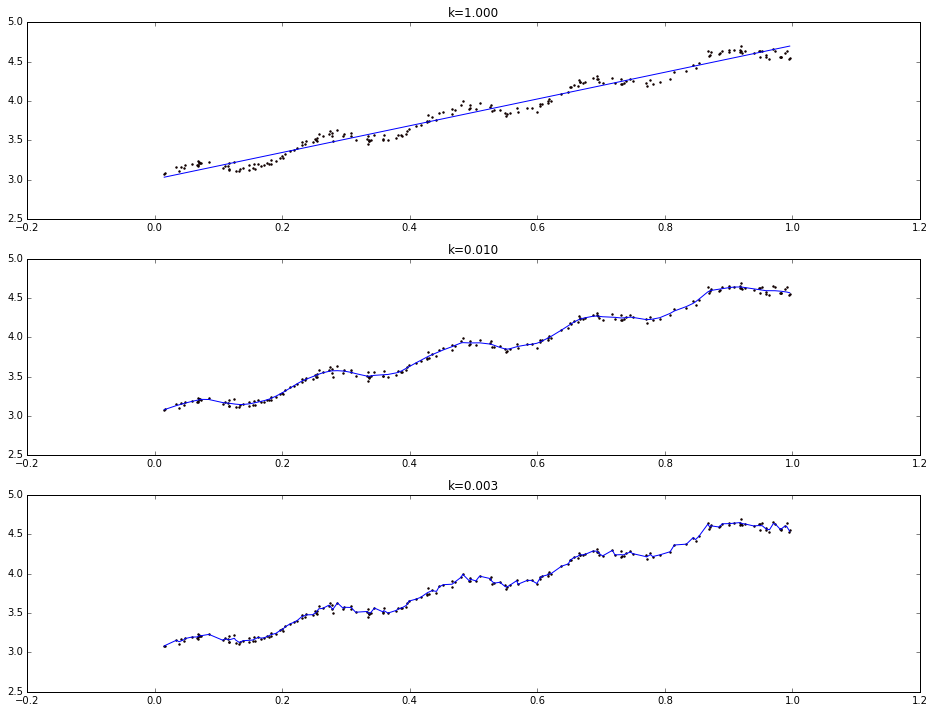

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16,12), subplot_kw={'adjustable': 'box-forced'}) # figsize=(16,10), 
ax = axes.ravel()

for i in range(len(y_hat_list)):
    ax[i].plot(x_sort[:,1], y_hat_list[i][srt_ind])
    ax[i].scatter(x_mat[:,1].flatten().A[0], np.mat(y_arr).T.flatten().A[0], s=2, c='r')
    ax[i].set_title('k=%.3f' % k_list[i])
plt.show()

## 示例：预测鲍鱼的年龄

In [9]:
def rss_error(y_arr, y_hat_arr):
    return ((y_arr - y_hat_arr) ** 2).sum()

ab_x, ab_y = load_data_set('data/regression/abalone.txt')
y_hat01_99 = lwlr_test(ab_x[0:99], ab_x[0:99], ab_y[0:99], 0.1)
y_hat01_199 = lwlr_test(ab_x[100:199], ab_x[0:99], ab_y[0:99], 0.1)
print("LWLR k=0.1, error on sample:%.2f, error on test:%.2f" % (rss_error(ab_y[0:99], y_hat01_99), rss_error(ab_y[100:199], y_hat01_199)))

y_hat1_99 = lwlr_test(ab_x[0:99], ab_x[0:99], ab_y[0:99], 1.0)
y_hat1_199 = lwlr_test(ab_x[100:199], ab_x[0:99], ab_y[0:99], 1.0)
print("LWLR k=1.0, error on sample:%.2f, error on test:%.2f" % (rss_error(ab_y[0:99], y_hat1_99), rss_error(ab_y[100:199], y_hat1_199)))

y_hat10_99 = lwlr_test(ab_x[0:99], ab_x[0:99], ab_y[0:99], 10)
y_hat10_199 = lwlr_test(ab_x[100:199], ab_x[0:99], ab_y[0:99], 10)
print("LWLR k=10, error on sample:%.2f, error on test:%s" % (rss_error(ab_y[0:99], y_hat10_99), rss_error(ab_y[100:199], y_hat10_199)))


ws = stand_regres(ab_x[0:99], ab_y[0:99])
y_hat = np.mat(ab_x[100:199]) * ws
print("stand regression, error on sample:%.2f, error on test:%.2f" % (rss_error(ab_y[0:99], y_hat.T.A), rss_error(ab_y[100:199], y_hat.T.A)))

LWLR k=0.1, error on sample:56.80, error on test:23726.20
LWLR k=1.0, error on sample:429.89, error on test:573.53
LWLR k=10, error on sample:549.12, error on test:517.571190538
stand regression, error on sample:3323.63, error on test:518.64


## 岭回归

特征比样本还多时，计算 $(X^TX)^{-1}$ 会出错。岭回归就是在矩阵 $X^TX$ 上加一个 $\lambda I$使得矩阵非奇异，进而能对 $X^TX + \lambda I$求逆。此时，回归系数的计算公式为：
$$ \hat{w} = (X^TX + \lambda I)^{-1}X^Ty $$

岭回归最先用来处理特征多于样本的问题，现在也用于在估计中加入偏差，从而得到更好的估计。通过引入 $\lambda$ 限制所有w的和，通过引入该惩罚项，能够减少不重要的参数，这个技术在统计学中也叫缩减（shrinkage）。

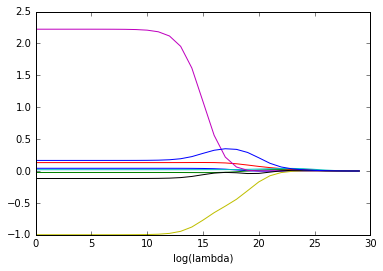

In [23]:
def ridge_regression(x_mat, y_mat, lam=0.2):
    """
    岭回归函数

    :param x_mat:
    :param y_mat:
    :param lam:
    :return:
    """
    x_tx = x_mat.T * x_mat
    denom = x_tx + np.eye(np.shape(x_mat)[1]) * lam
    if np.linalg.det(denom) == 0.0:
        print("this matrix is singular, cannot do inverse")
        return
    ws = denom.I * (x_mat.T * y_mat)
    return ws


def ridge_test(x_arr, y_arr):
    """
    岭回归测试：在不同lambda下回归系数的对比

    :param x_arr:
    :param y_arr:
    :return:
    """
    # 对特征进行标准化处理，使每个特征具有相同的重要性
    x_mat = np.mat(x_arr)
    y_mat = np.mat(y_arr).T
    y_mean = np.mean(y_mat, 0)
    y_mat = y_mat - y_mean
    x_means = np.mean(x_mat, 0)
    x_var = np.var(x_mat, 0)
    x_mat = (x_mat - x_means) / x_var

    num_test_pts = 30
    w_mat = np.zeros((num_test_pts, np.shape(x_mat)[1]))
    for i in range(num_test_pts):
        ws = ridge_regression(x_mat, y_mat, np.exp(i-10))  # lambda用指数，扩大取值范围
        w_mat[i, :] = ws.T
    return w_mat

ab_x, ab_y = load_data_set('data/regression/abalone.txt')
ridge_weights = ridge_test(ab_x, ab_y)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ridge_weights)
plt.xlabel('log(lambda)')
plt.show()